In [143]:
import pandas as pd
import quant_utils.data_moudle as dm
from quant_utils.constant_varialbles import TODAY
import riskfolio as rp
from quant_utils.performance import Performance, periods_performance
# 在matplotlib绘图中显示中文和负号
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.family'] = 'STKAITI' # 中文字体'STKAITI'
plt.rcParams['axes.unicode_minus'] = False   # 解决坐标轴负数的负号显示问题
# 关闭警告信息
import warnings
warnings.filterwarnings('ignore')

In [144]:
start_date='20170101'
end_date='20240627'
rename_dict = {
    "159941": "纳指ETF",
    "518880": "黄金ETF",
    "885062": "短债基金",
    "H00922": "中证红利全收益"
}

In [145]:
short_bond = dm.get_fund_index("885062", start_date=start_date, end_date=end_date)
ndx = dm.get_fund_adj_nav("159941", start_date=start_date, end_date=end_date).rename(
    columns={"ADJUST_NAV": "S_DQ_CLOSE"}
)
gold = dm.get_fund_adj_nav("518880", start_date=start_date, end_date=end_date).rename(
    columns={"ADJUST_NAV": "S_DQ_CLOSE"}
)
div_fund = dm.get_index_close("H00922", start_date=start_date, end_date=end_date)

In [146]:
close_df = pd.concat([short_bond, ndx, gold, div_fund])
close_df = close_df.pivot_table(
    index="TRADE_DT", 
    columns="TICKER_SYMBOL", 
    values="S_DQ_CLOSE"
).dropna()
close_df = close_df.pct_change().dropna()
close_df.rename(columns=rename_dict, inplace=True)
# close_df = close_df[close_df.index >= "20190101"]

In [147]:
port = rp.Portfolio(returns=close_df)

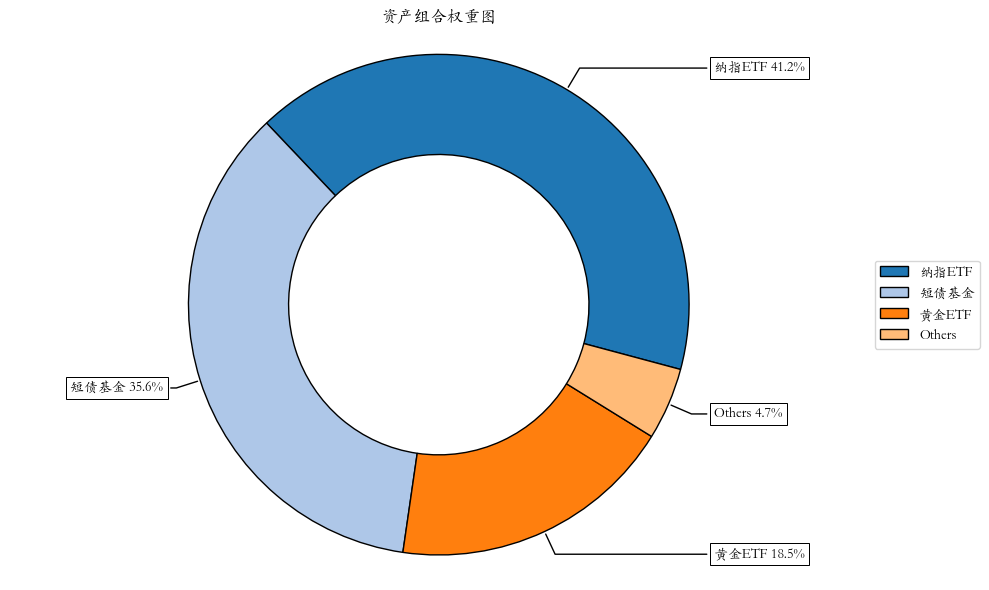

In [148]:
# 选择模型和目标函数

# 选择估算方法
method_mu='ewma1' # 基于历史数据估算预期收益的方法
method_cov='ewma1' # 基于历史数据估算协方差矩阵的方法

# 使用选择的方法估算参数
port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

model='Classic' # 模型可以是 Classic（经典）、BL（Black Litterman）或 FM（Factor Model）
rm = 'MV' # 使用的风险度量，这里我们使用标准差
obj = 'Sharpe' # 优化的目标，可以是 MinRisk, MaxRet, Utility 或 Sharpe
hist = True # 是否使用历史场景来计算依赖于场景的风险度量
rf = 0 # 无风险利率
l = 0 # 风险厌恶因子，仅在目标函数为 'Utility' 时有用
port.nea = 3
# 估算最优投资组合权重
w = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)
# 设置投资组合的资产数量不少于5个

# 可视化资产组合权重图
ax = rp.plot_pie(
    w=w, 
    title='资产组合权重图', 
    others=0.05, 
    nrow=25, 
    cmap="tab20", 
    height=6, 
    width=10, 
    ax=None
)

In [149]:
w

,weights
纳指ETF,0.412425
黄金ETF,0.184664
短债基金,0.356326
中证红利全收益,0.046585


<Axes: xlabel='TRADE_DT'>

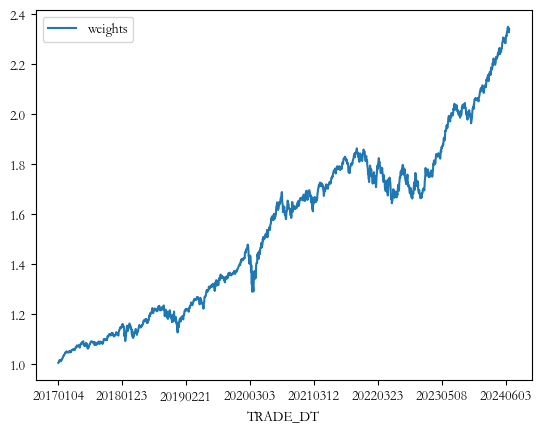

In [150]:
nav = (close_df.dot(w) + 1).cumprod()
nav.plot()

In [151]:
close_df.corr()

TICKER_SYMBOL,纳指ETF,黄金ETF,短债基金,中证红利全收益
TICKER_SYMBOL,,,,
纳指ETF,1.000000,-0.020197,-0.010671,0.107783
黄金ETF,-0.020197,1.000000,0.068698,0.020135
短债基金,-0.010671,0.068698,1.000000,-0.124568
中证红利全收益,0.107783,0.020135,-0.124568,1.000000


In [152]:
Performance(nav["weights"]).stats().T

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,20170104,20240625,1.330288,0.1198,0.100263,1.194862,0.127843,0.937085,20200316,53


In [153]:
w = pd.DataFrame(
    [0.07, 0.07, 0.79, 0.07], 
    index = ['纳指ETF','黄金ETF','短债基金','中证红利全收益'],
    columns=["weights"]
)
w

,weights
纳指ETF,0.07
黄金ETF,0.07
短债基金,0.79
中证红利全收益,0.07


In [154]:
close_df

TICKER_SYMBOL,纳指ETF,黄金ETF,短债基金,中证红利全收益
TRADE_DT,,,,
20170104,0.006015,0.004628,0.000134,0.008263
20170105,0.002550,-0.000528,0.000097,0.001099
20170106,-0.000526,0.002115,-0.000107,-0.004302
20170109,0.012110,0.002263,0.000299,0.005727
20170110,0.001647,0.008351,0.000541,-0.002774
...,...,...,...,...
20240619,0.000000,0.004390,0.000118,-0.002921
20240620,-0.007432,0.007780,0.000090,-0.002146
20240621,-0.002714,0.003440,-0.000024,0.000443


<Axes: xlabel='TRADE_DT'>

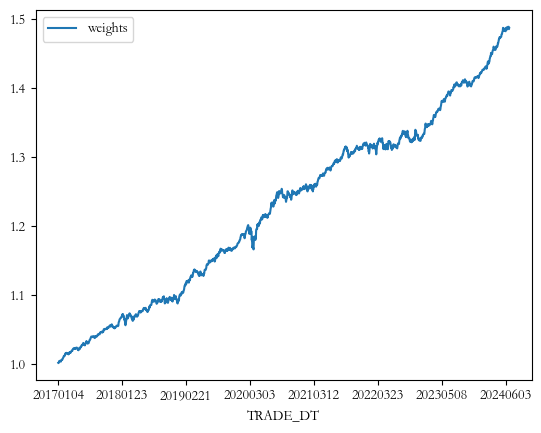

In [155]:
nav = (close_df.dot(w) + 1).cumprod()
nav.plot()

In [156]:
Performance(nav["weights"]).stats().T

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,20170104,20240625,0.485081,0.054317,0.023143,2.347002,0.029356,1.850322,20200323,22


In [157]:
nav.to_excel("d:/模拟净值.xlsx")

In [158]:
df_nav = pd.read_excel("d:/892400.MI.xlsx", sheet_name="Sheet1")
df_nav.set_index("TRADE_DT", inplace=True)

In [159]:
Performance(df_nav["沪深300"]).stats().T

,起始日期,结束日期,累计收益率,年化收益率,年化波动率,收益波动比,最大回撤,年化收益回撤比,最大回撤日,最大回撤修复
0,2016-12-30 00:00:00,2024-03-29 00:00:00,0.0687,0.009215,0.178919,0.051501,0.452517,0.020363,20240202,99999


In [160]:
periods_performance(nav["weights"]).to_excel("d:/分年度.xlsx")

In [161]:
Performance(nav["weights"]).rolling_ret_stats().to_excel("d:/胜率.xlsx")